# Entrenamiento de modelos de aprendizaje con el dataset Polyvore

**Autor:** Roberto Araya Day

**Fecha de inicio:** 16/11/2022

## 1. Preparación de datos

- El archivo *type_aware_polyvore_outfits.py* es el script de **Learning Type Aware Embeddings for Fashion Compatibility** para cargar el dataset de Polyvore y crear ejemplos. Se define un **TripletImageLoader** con una serie de transformaciones para las imágenes. Este archivo retorna *Triplets* de imágenes postivas y negativas. Modificamos este archivo en la forma de **DoubletImageLoader** para retornar pares de imágenes. Revisar el archivo. 
- El archivo *similarity_conditions_triplet_image_loader.py* es el script de **Learning similarity Conditions** para cargar triplets de datos de Polyvore. Revisar.

- Se dividen en los archivos:
    - ***fashion_compatibility_prediction.txt***: En ***fashion_compatibility_prediction_val.txt*** y ***fashion_compatibility_prediction_test.txt*** para las métricas de validación y testeo. Puesto que el archivo contiene **7076** columnas, se ponen **3538** ejemplos en cada archivo.
    - ***fill_in_blank_test.txt***.
---

Los modelos de recomendación están conformados por la siguiente estructura:
1. **DoubletImageLoader**: Carga las imágenes, con sus metadatos, y se crean los ejemplos de pares de prendas positivos. Es decir, prendas compatibles. Esta basado en los dataloader de ambas investigaciones señaladas anteriormente.
    - Un DataLoader es una estructura que combina un dataset y un sampler, y provee un iterador sobre el dataset.


2. **DoubletNet**: Genera los embeddings y calcula la pérdida y distancia entre los vectores obtenidos de los ejemplos positivos. No se necesita para este caso, puesto que el **Modelo General** lo hace por si solo. No necesita obtener el loss o accuracy de los pares de imágenes.


3. **Modelo General**: Variante del modelo BYOL que recibe dos imágenes de entrada.

## 2. Instalación de los modelos de aprendizaje
### 2.1 Instalación del modelo Type-aware

Se instala y configura el modelo Type-aware del trabajo *Learning Type-aware Models for Fashion Compatibility* de Vasilevia et al. El modelo se puede encontrar en el siguiente [enlace](https://github.com/mvasil/fashion-compatibility).

In [1]:
import sys
import os
sys.path.append('/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages')

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload

In [4]:
%autoreload 2

In [6]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from polyvore_outfits import TripletImageLoader
from tripletnet_original import Tripletnet
from type_specific_network import TypeSpecificNet
import sys


test_arg = False
use_fc_arg = True
learned_arg = True
prein_arg = True
epochs_args = 10
batch_size_args = 200
learning_rate_args = 5e-5
num_conditions = 5
learned_metric_arg = False
dim_embed_arg = 64
margin_arg = 0.3


# names of model
name_arg = 'type_aware_%s_epochs_fc_%s_prein_%s' % (epochs_args, use_fc_arg, prein_arg)
resume_arg =  'runs/trained_models/%s/checkpoint.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=dim_embed_arg, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=True,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=learned_metric_arg,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"

def main():
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    print('cuda activated: ', args.cuda)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)
    
    # definition of the model
    ## Type aware model
    model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
    csn_model = TypeSpecificNet(args, model, len(test_loader.dataset.typespaces))

    criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    if args.cuda:
        tnet.cuda()

    train_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'train', meta_data,
                           text_dim=text_feature_dim,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    val_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'valid', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    best_acc = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            tnet.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True    
    if args.test:
        test_acc = test(test_loader, tnet)
        sys.exit()

    parameters = filter(lambda p: p.requires_grad, tnet.parameters())
    optimizer = optim.Adam(parameters, lr=args.lr)
    n_parameters = sum([p.data.nelement() for p in tnet.parameters()])
    print('  + Number of params: {}'.format(n_parameters))

    for epoch in range(args.start_epoch, args.epochs + 1):
        # update learning rate
        adjust_learning_rate(optimizer, epoch)
        # train for one epoch
        train(train_loader, tnet, criterion, optimizer, epoch)
        # evaluate on validation set
        acc = test(val_loader, tnet)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': tnet.state_dict(),
            'best_prec1': best_acc,
        }, is_best)

    checkpoint = torch.load('runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
    tnet.load_state_dict(checkpoint['state_dict'])
    test_acc = test(test_loader, tnet)
    
    
def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
    
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_vse, loss_sim_t, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        loss_sim = args.sim_t_loss * loss_sim_t + args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet + loss_reg
        if args.vse_loss > 0:
            loss += loss_vse_w
        if args.sim_t_loss > 0 or args.sim_i_loss > 0:
            loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        mask_norms.update(loss_mask.item())
            
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))

            
def test(test_loader, tnet):
    # switch to evaluation mode
    tnet.eval()
    embeddings = []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images in enumerate(test_loader):
        if args.cuda:
            images = images.cuda()
        images = Variable(images)
        embeddings.append(tnet.embeddingnet(images).data)
        
    embeddings = torch.cat(embeddings)
    metric = tnet.metric_branch
    auc = test_loader.dataset.test_compatibility(embeddings, metric)
    acc = test_loader.dataset.test_fitb(embeddings, metric)
    acc_var = test_loader.dataset.test_fitb_var(embeddings, metric)
    total = auc + acc + acc_var
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n FITB_var: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1), round(acc_var * 100, 1)))
    
    return total



class TrainData():
    def __init__(self, images, text, has_text, conditions = None):
        has_text = has_text.float()
        if args.cuda:
            images, text, has_text = images.cuda(), text.cuda(), has_text.cuda()
        images, text, has_text = Variable(images), Variable(text), Variable(has_text)
        
        if conditions is not None and not args.use_fc:
            if args.cuda:
                conditions = conditions.cuda()

            conditions = Variable(conditions)
        
        self.images = images
        self.text = text
        self.has_text = has_text
        self.conditions = conditions

    def __len__(self):
        return self.images.size(0)

    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/trained_models/%s/"%(args.name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
        
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * ((1 - 0.015) ** epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

        
if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    main()

cuda activated:  True
=> loading checkpoint 'runs/trained_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar'
=> loaded checkpoint 'runs/trained_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar' (epoch 8)
  + Number of params: 3462144
Train Epoch: 8 [0/686851]	Loss: 0.0161 (0.0161) 	Acc: 99.00% (99.00%) 	Emb_Norm: 0.96 (0.96)
Train Epoch: 8 [2000/686851]	Loss: 0.0280 (0.0541) 	Acc: 98.50% (95.00%) 	Emb_Norm: 0.99 (1.01)
Train Epoch: 8 [4000/686851]	Loss: 0.0167 (0.0575) 	Acc: 99.50% (94.14%) 	Emb_Norm: 0.91 (0.97)
Train Epoch: 8 [6000/686851]	Loss: 0.0917 (0.0800) 	Acc: 93.50% (90.60%) 	Emb_Norm: 0.93 (0.98)
Train Epoch: 8 [8000/686851]	Loss: 0.0000 (0.0771) 	Acc: 100.00% (90.55%) 	Emb_Norm: 0.97 (0.97)
Train Epoch: 8 [10000/686851]	Loss: 0.0565 (0.0765) 	Acc: 94.00% (90.72%) 	Emb_Norm: 0.93 (0.96)
Train Epoch: 8 [12000/686851]	Loss: 0.0096 (0.0658) 	Acc: 99.50% (92.10%) 	Emb_Norm: 0.95 (0.96)
Train Epoch: 8 [14000/686851]	Loss: 0.0160 (0.0593) 	Acc: 99.

KeyboardInterrupt: 

## 3. Sistema de recuperacion de prendas

Se obtienen los embeddings de las imagenes de testeo dado el modelo BYOL entrenado. Las funciones a continuacion se basan del trabajo de *Javier Morales Rodriguez* del repositorio *bimodal-byol-shoes*:
- https://github.com/javier-op/bimodal-byol-shoes.


### 3.1 Definicion de funciones
Se programan las funciones:
- *get_embeddings_labels*: Recibe un modelo BYOL, una lista de la direccion de las categorias y una transformacion de pytorch para obtener todos los embeddings del modelo BYOL entrenado.
- *right_border_image*: Agrega una linea vertical en negro a la derecha de una imagen de entrada.
- *plot_best_10_multiple*: Crea una figura plot para mostrar todas las imagenes que se encuentren cerca de una imagen de entrada en un espacio de representaciones. En definitiva, implementa NearestNeighbor dada una imagen de entrada y obtiene todas las imagenes cercanas.
- *plot_best_10_multiple_category*: Crea una figura plot para mostrar todas las imagenes que se encuentren cerca de una imagen de entrada en un espacio de representaciones y que correspondan a una categoria que se entrega de entrada. En definitiva, implementa NearestNeighbor dada una imagen de entrada y obtiene todas las imagenes cercanas que correspondan a una cierta categoria.

In [65]:
from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
import torch
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms
import json
import Resnet_18
import os



def image_loader(img):
    """Loads and converts an image to RGB format using PIL."""
    
    return Image.open(img).convert('RGB')


def get_embeddings_labels(model, img_path, transform=None, batch_size=20):
    """Obtains the embeddings of a list of images using a given model."""
    
    model.eval()
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)

    with torch.no_grad():
        for i in range(0, len(img_path), batch_size):
            batch_images = []
            for j in range(i, min(i + batch_size, len(img_path))):
                img = image_loader(img_path[j])
                if transform is not None:
                    img = transform(img)
                batch_images.append(img)
            
            batch_images = torch.stack(batch_images).to(device)
            batch_embeddings = model(batch_images)
            embeddings.append(batch_embeddings.cpu())

    embeddings = torch.cat(embeddings, dim=0)
    return embeddings


def right_border_image(img, border_width, value=(0,0,0)):
    """Adds a right border to an image."""
    b = border_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((ny, nx+b))*value[0],
        np.ones((ny, nx+b))*value[1],
        np.ones((ny, nx+b))*value[2]
    ]).transpose(1,2,0)
    framed_img = framed_img.astype(np.uint8)
    framed_img[:,:-b,:] = img
    return framed_img

transform_images = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor()
])


def get_typespace(typespaces, anchor, pair):
    """ Returns the index of the type specific embedding
        for the pair of item types provided as input
    """
    query = (anchor, pair)
    if query not in typespaces:
        query = (pair, anchor)

    return typespaces[query]


def plot_best_10_multiple_category(images_path, images_embeddings, images_categories, output_category, typespaces, 
                                   selected_indices, discard_first=True, lines_width=8, transform=transform_images):
    images_embeddings = images_embeddings.cpu().numpy()
    """Plots the best 10 images of a specific category, given a list of selected indices."""
    
    
    category_indexes = [i for i, category in enumerate(images_categories) if category == output_category]
    category_images_embeddings = images_embeddings[category_indexes]
    
    category_images_path = [images_path[i] for i in category_indexes]
    category_images_categories = [images_categories[i] for i in category_indexes]
    
    
    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=11, figsize=(int(11*1.5), int(len(selected_indices)*1.5)))
    
    
    for i, selected_idx in enumerate(selected_indices):
        selected_image_embedding = images_embeddings[selected_idx]
        selected_image_path = images_path[selected_idx]
        selected_image_category = images_categories[selected_idx]
        
        condition = get_typespace(typespaces, selected_image_category, output_category)
        
        # obtain embeddings condition-specific
        category_images_embeddings_i = category_images_embeddings[:, condition, :]
        selected_image_embedding = selected_image_embedding[condition, :]
        
        distances = np.sqrt(np.sum(np.square(category_images_embeddings_i - selected_image_embedding), 1))
        
        indices = np.argsort(distances)
        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[0:10]
            
        best_path = []
        best_categories = []
        for idx in best_indices:
            best_path.append(category_images_path[idx])
            best_categories.append(category_images_categories[idx])
        
        selected = image_loader(selected_image_path)
        selected = np.array(selected)
        selected_category = selected_image_category
        
        # add left border to image
        selected = right_border_image(selected,lines_width)
        
        axes[i][0].imshow(selected.astype(np.uint8))
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        for j, index in enumerate(range(len(best_path))):
            img_category = best_categories[index]
            image = image_loader(best_path[index])
            image = np.array(image)
            
            axes[i][j+1].imshow(image.astype(np.uint8))
            axes[i][j+1].axis('off')
    return fig, axes




def plot_best_10_multiple_category(images_path, images_embeddings, images_categories, output_category, typespaces, 
                                   selected_indices, transform, discard_first=True, lines_width=8):
    images_embeddings = images_embeddings.cpu().numpy()
    
    
    category_indexes = [i for i, category in enumerate(images_categories) if category == output_category]
    category_images_embeddings = images_embeddings[category_indexes, :, :]
    
    category_images_path = [images_path[i] for i in category_indexes]
    category_images_categories = [images_categories[i] for i in category_indexes]

    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=11, figsize=(int(11*1.5), int(len(selected_indices)*1.5)))

    for i, selected_idx in enumerate(selected_indices):
        selected_image_embedding = images_embeddings[selected_idx]
        selected_image_path = images_path[selected_idx]
        selected_image_category = images_categories[selected_idx]

        condition = get_typespace(typespaces, selected_image_category, output_category)

        # obtain embeddings condition-specific
        category_images_embeddings_i = category_images_embeddings[:, condition]
        selected_image_embedding = selected_image_embedding[condition]

        distances = np.sqrt(np.sum(np.square(category_images_embeddings_i - selected_image_embedding), axis=1))

        indices = np.argsort(distances)
        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[:10]

        best_path = [category_images_path[idx] for idx in best_indices]
        best_categories = [category_images_categories[idx] for idx in best_indices]

        selected = image_loader(selected_image_path)
        selected = np.array(selected)
        selected_category = selected_image_category

        # add left border to image
        selected = right_border_image(selected, lines_width)

        axes[i][0].imshow(selected.astype(np.uint8))
        axes[i][0].axis('off')
        
        for j, img_path in enumerate(best_path):
            image = image_loader(img_path)
            image = np.array(image)

            axes[i][j+1].imshow(image.astype(np.uint8))
            axes[i][j+1].axis('off')

    return fig, axes

### 3.2 Obtencion de tensores
Se obtiene la informacion solo de los datos de testeo (no en entrenamiento). Si es que se quiere cambiar esto y obtener *NearestNeighbor* con los datos de entrenamiento - Cambiar:

data_json = os.path.join(rootdir, 'test.json') para incluir los datos de entrenamiento.

In [66]:
import Resnet_18
from polyvore_outfits import TripletImageLoader
from tripletnet_original import Tripletnet
from type_specific_network import TypeSpecificNet
import sys
import pickle
import argparse

test_arg = True
use_fc_arg = True
learned_arg = True
prein_arg = True
epochs_args = 10
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
learned_metric_arg = False
dim_embed_arg = 64
margin_arg = 0.3


name_arg = 'type_aware_%s_epochs_fc_%s_prein_%s' % (epochs_args, use_fc_arg, prein_arg)
resume_arg =  'runs/trained_models/%s/checkpoint.pth.tar' % (name_arg)


parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=dim_embed_arg, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=True,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=learned_metric_arg,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"

def main():
    global args
    
    args = parser.parse_args()
    # names of model

    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    cuda = torch.cuda.is_available()

    if cuda: torch.cuda.manual_seed(1)

    # sistema de recuperacion solo en los datos de testeo
    # se leen los archivos relevantes, archivo de metadatos, carpeta donde se encuentran las imagenes no disjuntas.
    fn = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    rootdir = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'nondisjoint')
    impath = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'images')

    # se abren los datos de entrenamiento
    data_json = os.path.join(rootdir, 'test.json')
    outfit_data = json.load(open(data_json, 'r'))

    typespaces_load = pickle.load(open('typespaces.p','rb'))
    
    typespaces = {}
    for index, t in enumerate(typespaces_load):
        typespaces[t] = index

    # lists to save outfits data, general data of all items and positive pairs of items
    cat_list, index_list, path_list = [], [], []

    # get list of images and make a mapping used to quickly organize the data
    contador = 0
    for outfit in outfit_data:
        outfit_id = outfit['set_id']

        for item in outfit['items']:
            im = item['item_id']

            # image path, category and compute color variance
            im_path = os.path.join(impath, '%s.jpg' % im)
            im_category = meta_data[im]['semantic_category']

            # append image path, category and color variance to general lists
            index_list.append(im)
            path_list.append(im_path)
            cat_list.append(im_category)


    # loading the models
    model = Resnet_18.resnet18(pretrained=True, embedding_size=dim_embed_arg)
    csn_model = TypeSpecificNet(args, model, len(typespaces))
    
    #text_feature_dim = 6000
    #criterion = torch.nn.MarginRankingLoss(margin = margin_arg)
    #tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)

    if os.path.isfile(resume_arg):
        print("=> loading checkpoint '{}'".format(resume_arg))
        checkpoint = torch.load(resume_arg,encoding='latin1')
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_prec1']
        
        
        #tnet.load_state_dict(checkpoint['state_dict'])
        
        # new model state
        new_model_state = {}
        model_state = checkpoint['state_dict']
        for key in model_state.keys():
            if key[0:12] == 'embeddingnet':
                new_model_state[key[13:]] = model_state[key]
        csn_model.load_state_dict(new_model_state)
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume_arg, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume_arg))
    
    return csn_model, path_list, cat_list, typespaces



learner, path_list, cat_list = None, None, None
if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    learner, path_list, cat_list, typespaces = main()

=> loading checkpoint 'runs/trained_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar'
=> loaded checkpoint 'runs/trained_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar' (epoch 8)


In [67]:
# transformation applied to image
img_transform = transforms.Compose([transforms.Resize(112), transforms.CenterCrop(112), transforms.ToTensor()])
image_embeddings = get_embeddings_labels(learner, path_list, transform=img_transform, batch_size=20)

In [68]:
print(image_embeddings.shape)

torch.Size([53506, 67, 64])


(<Figure size 1600x700 with 55 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
      

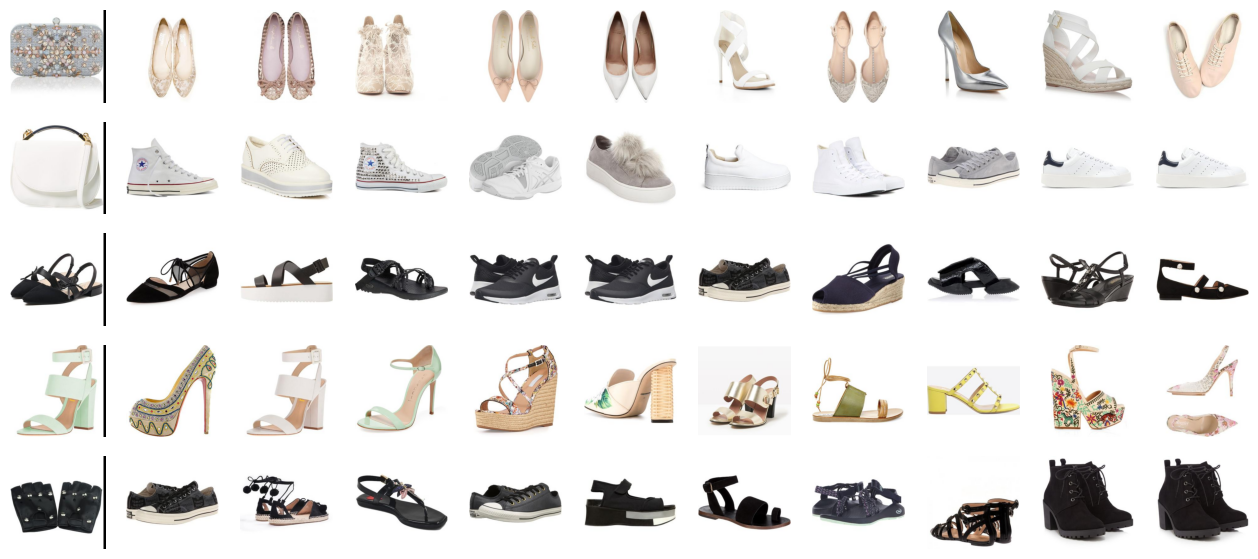

In [69]:

img_transform = transforms.Compose([transforms.Resize(112), transforms.CenterCrop(112), transforms.ToTensor()])
plot_best_10_multiple_category(path_list, image_embeddings, cat_list, 'shoes', typespaces, [0,105,200,300,400], transform=img_transform)

## 4. Exportar modelos y datos importantes

Se exporta el modelo de *Type-Aware* entrenado y parametros importantes para cargarlos en el proyecto de *Django* (o recuperarlo para otras tarea de obtencion de embeddings).

In [64]:
import pickle
import os

# save important information in folders
name_arg = 'type_aware_%s_epochs_fc_%s_prein_%s' % (epochs_args, use_fc_arg, prein_arg)
model_directory = os.path.join(os.path.dirname(os.getcwd()), 'django_param', name_arg)
print(model_directory)

if not os.path.exists(model_directory):
   # Create a new directory because it does not exist
   os.makedirs(model_directory)

    
params = {
    'use_fc': use_fc_arg,
    'learned': learned_arg,
    'prein': prein_arg,
    'epochs': epochs_args,
    'batch_size': batch_size_args,
    'learning_rate': learning_rate_args,
    'num_conditions': 5,
    'learned_metric': learned_metric_arg,
    'dim_embed': dim_embed_arg,
    'margin': margin_arg
}

    
# save embeddings and dump dictionary

torch.save(learner.state_dict(), os.path.join(model_directory, 'model_state_dict.pth.tar'))
torch.save(image_embeddings, os.path.join(model_directory, 'embedding_list.pt'))
dump_dict = {'images_list': path_list, 'cat_list': cat_list, 'params': params}
pickle.dump(dump_dict, open(os.path.join(model_directory, "other_info.p"), "wb"))

# load state dictionary for csanet
learner.load_state_dict(torch.load(os.path.join(model_directory, 'model_state_dict.pth.tar'),encoding='latin1'))

/home/raraya/fashion_proj/fashion_models/django_param/type_aware_10_epochs_fc_True_prein_True


<All keys matched successfully>